# 텍스트 분류

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt', header=0, delimiter='\t' ,quoting=3)
test = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt', header=0, delimiter='\t' ,quoting=3)
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
train['document'].nunique()

146182

In [ ]:
train.drop_duplicates('document', inplace = True)

In [ ]:
train.dropna(inplace=True)

In [ ]:
train['label'].value_counts()

,count
label,
0,73342
1,72840


<Axes: xlabel='label', ylabel='count'>

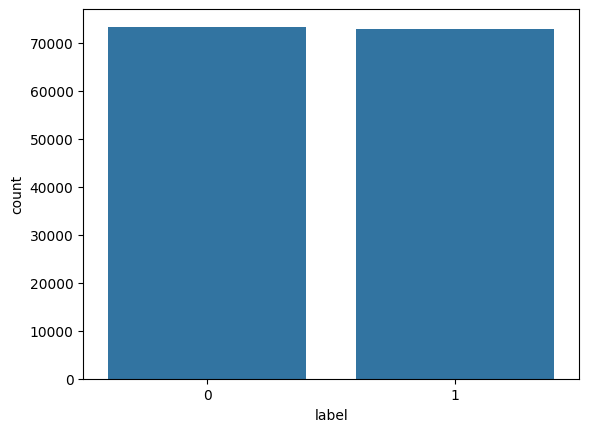

In [ ]:
import seaborn as sns
sns.countplot(
    data = train,
    x = 'label'
)

49157


<Axes: xlabel='label', ylabel='count'>

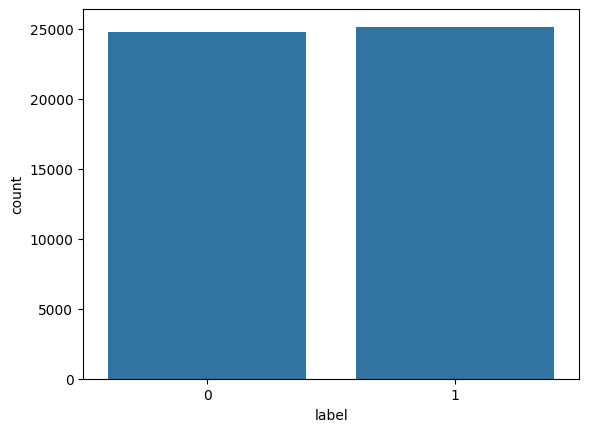

In [ ]:
print(test['document'].nunique())
test.drop_duplicates('document')
test.dropna(inplace=True)

sns.countplot(
    data = test,
    x = 'label'
)

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 34.8 MB/s eta 0:00:00


In [ ]:
import re
from konlpy.tag import Okt

In [ ]:
def preprocessing(review):
    okt = Okt()

    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review) # 정규 표현식

    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.pos(review_text, stem=True)

    # 3. 불용어 제거
    stop_words = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
    word_review = [(token, pos) for token, pos in word_review if not token in stop_words]

    # 4. 노이즈 제거 (글자 1개는 노이즈로 간주하자.)
    word_review = [(token, pos) for token, pos in word_review if len(token) > 1]

    # 5. 명사, 동사, 형용사 추출
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective']]

    return word_review

In [ ]:
train_review = []
test_review = []
train_label = []
test_label = []

train_num = 30000
for review in tqdm(train[train['label'] == 1]['document'].iloc[:train_num]):
    train_review.append(preprocessing(review))
train_label += [1] * train_num

for review in tqdm(train[train['label'] == 0]['document'].iloc[:train_num]):
    train_review.append(preprocessing(review))
train_label += [0] * train_num

test_num = 5000
for review in tqdm(test[test['label'] == 1]['document'].iloc[:test_num]):
    test_review.append(preprocessing(review))
test_label += [1] * test_num

for review in tqdm(test[test['label'] == 0]['document'].iloc[:test_num]):
    test_review.append(preprocessing(review))
test_label += [0] * test_num

print()
print(train_review[:5])

100%|██████████| 5000/5000 [00:16<00:00, 311.44it/s]


[['포스터', '보고', '초딩', '영화', '오버', '연기', '가볍다', '않다'], ['몬페', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '늙다', '보이다', '하다', '커스틴', '던스트', '이쁘다', '보이다'], ['액션', '없다', '재미', '있다', '안되다', '영화'], ['왜케', '평점', '낮다', '헐리우드', '화려하다', '길들이다', '있다'], ['인피니트', '진짜']]


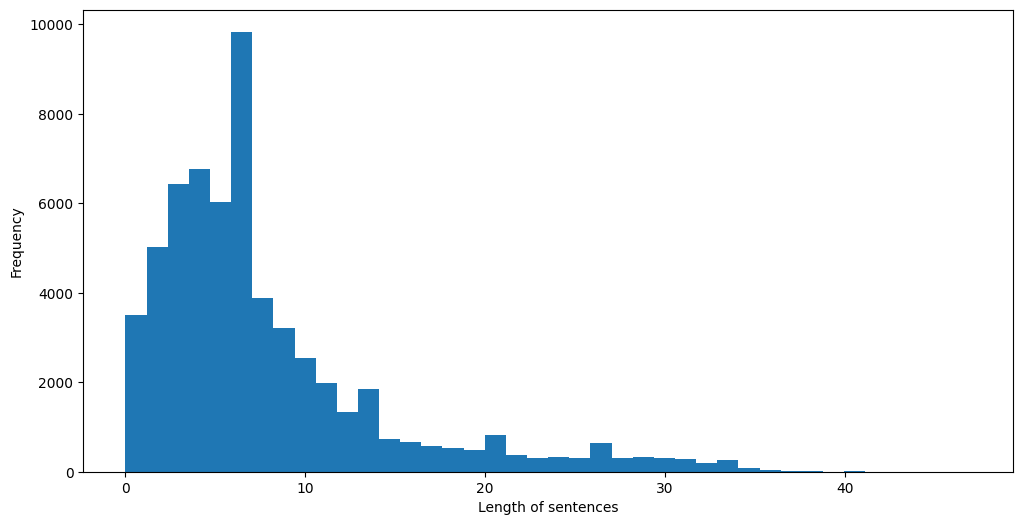

In [ ]:

from matplotlib import pyplot as plt
# sequence 길이 통계 및 시각화
lengths = [len(sentence) for sentence in train_review]
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=40)
plt.xlabel('Length of sentences')
plt.ylabel('Frequency')
plt.show()

In [ ]:
max_len = 35

In [ ]:
from collections import Counter
word_counter = Counter(word for sentence in train_review for word in sentence)
print(word_counter.most_common(10))
print(word_counter.most_common()[-10:])

[('영화', 20727), ('하다', 16883), ('보다', 15671), ('없다', 6399), ('있다', 5018), ('좋다', 4880), ('정말', 3894), ('재밌다', 3671), ('되다', 3616), ('진짜', 3439)]
[('문승원', 1), ('지단', 1), ('손꼭', 1), ('기장', 1), ('액선', 1), ('거름', 1), ('띄엄띄엄', 1), ('스나총', 1), ('뜷있늬', 1), ('광택', 1)]


In [ ]:
vocab = {word: i + 2 for i, (word, count) in enumerate(word_counter.most_common()) if count >= 10}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

for word, idx in vocab.items():
    print(f"{word}: {idx}", end = ', ')
    if idx > 20:
        break
print()
print('total vocab size:', len(vocab))

영화: 2, 하다: 3, 보다: 4, 없다: 5, 있다: 6, 좋다: 7, 정말: 8, 재밌다: 9, 되다: 10, 진짜: 11, 이다: 12, 같다: 13, 않다: 14, 아니다: 15, 만들다: 16, 평점: 17, 나오다: 18, 연기: 19, 최고: 20, 생각: 21, 
total vocab size: 4353


In [ ]:
def encode(sentence, max_length=50):

    text_seq = [vocab.get(word, vocab["<UNK>"]) for word in sentence]
    if len(text_seq) < max_length:
        text_seq += [vocab["<PAD>"]] * (max_length - len(text_seq))
    else:
        text_seq = text_seq[:max_length]
    return text_seq

train_seq = [torch.tensor(encode(sentence, max_len)) for sentence in train_review]
test_seq = [torch.tensor(encode(sentence, max_len)) for sentence in test_review]
test_seq[:5]

[tensor([430,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0]),
 tensor([ 119, 1908,   10,   20,  119,    2,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([1857, 1008, 2133,  324, 2276, 3381,  191,   25,   48,   14,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([79,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([ 668,   83,   83, 3717, 2407,  281,    1,   83,   36,    1,  909,   83,
            1,   13, 3238,    2,    0,    0,    0,    0,    0,    0,    0,   

In [ ]:
i2s = {idx: word for word, idx in vocab.items()}
# 인코딩된 seq를 단어로 복원
def decode(sequence):
    word_seq = [i2s[int(w)] for w in sequence]
    return word_seq

print(decode(test_seq[2]))

['이별', '아픔', '찾아오다', '새롭다', '인연', '기쁨', '모든', '사람', '그렇다', '않다', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_seq, train_label, test_size=0.1, random_state=42
)

In [ ]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [ ]:
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(test_seq, test_label)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Attention model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)  # 짝수 인덱스
        pe[:, 1::2] = torch.cos(position * div_term)  # 홀수 인덱스
        pe = pe.unsqueeze(0)  # (1, max_len, embedding_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, embedding_dim)
        x = x + self.pe[:, :x.size(1), :]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)

    def forward(self, x):
        attn_output, attn_weights = self.attention(x, x, x)
        return attn_output, attn_weights

class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, output_dim, max_len=512):
        super(TransformerSentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len=max_len)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embedding_dim))

        self.attention_layers = nn.ModuleList([
            MultiHeadSelfAttention(embedding_dim, num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.pos_encoder(embedded)

        batch_size = embedded.size(0)
        cls_tokens = self.cls_token.expand(batch_size, 1, -1)
        x = torch.cat((cls_tokens, embedded), dim=1)  # (batch, seq+1, emb)

        attn_weights = None
        for i, attn_layer in enumerate(self.attention_layers):
            # mask 넣어보기, where...
            x, attn = attn_layer(x)
            if i == len(self.attention_layers) - 1:
                attn_weights = attn  # 마지막 레이어의 attention만 반환

        cls_output = x[:, 0, :]
        output = self.fc(cls_output)  # (batch_size, output_dim)
        return output, attn_weights


In [ ]:
# 하이퍼파라미터
embedding_dim = 64
num_heads = 8
num_layers = 2
output_dim = 1  # 이진 분류

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화
model = TransformerSentimentClassifier(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_dim=output_dim
).to(device)

criterion = nn.BCEWithLogitsLoss()  # 로짓 출력 + 시그모이드는 내부적으로 처리됨
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 학습 루프
train_loss_history = []
val_loss_history = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)

        optimizer.zero_grad()
        output, _ = model(X_batch)
        loss = criterion(output.squeeze(1), y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss_history.append(total_loss / len(train_loader))

    # 검증
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.float().to(device)
            output, _ = model(X_batch)
            val_loss = criterion(output.squeeze(1), y_batch)
            total_val_loss += val_loss.item()
        val_loss_history.append(total_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {total_loss / len(train_loader):.4f}, "
          f"Val Loss: {total_val_loss / len(val_loader):.4f}")

100%|██████████| 106/106 [00:02<00:00, 50.96it/s]


Epoch 1/10, Train Loss: 0.5892, Val Loss: 0.5095


100%|██████████| 106/106 [00:00<00:00, 163.74it/s]


Epoch 2/10, Train Loss: 0.4775, Val Loss: 0.4726


100%|██████████| 106/106 [00:00<00:00, 158.55it/s]


Epoch 3/10, Train Loss: 0.4422, Val Loss: 0.4499


100%|██████████| 106/106 [00:00<00:00, 161.52it/s]


Epoch 4/10, Train Loss: 0.4160, Val Loss: 0.4392


100%|██████████| 106/106 [00:00<00:00, 162.25it/s]


Epoch 5/10, Train Loss: 0.3974, Val Loss: 0.4295


100%|██████████| 106/106 [00:00<00:00, 161.51it/s]


Epoch 6/10, Train Loss: 0.3837, Val Loss: 0.4289


100%|██████████| 106/106 [00:00<00:00, 160.81it/s]


Epoch 7/10, Train Loss: 0.3720, Val Loss: 0.4222


100%|██████████| 106/106 [00:00<00:00, 160.77it/s]


Epoch 8/10, Train Loss: 0.3606, Val Loss: 0.4255


100%|██████████| 106/106 [00:00<00:00, 161.87it/s]


Epoch 9/10, Train Loss: 0.3518, Val Loss: 0.4216


100%|██████████| 106/106 [00:00<00:00, 162.48it/s]

Epoch 10/10, Train Loss: 0.3408, Val Loss: 0.4270


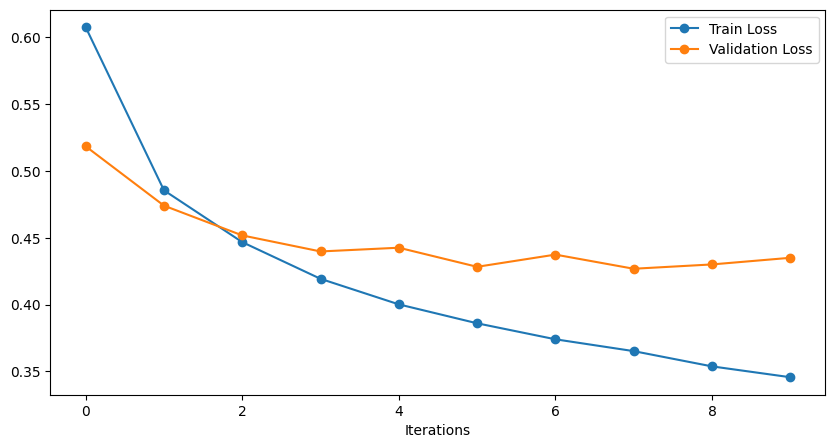

In [ ]:
# train val loss 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, 'o-', label='Train Loss')
plt.plot(val_loss_history, 'o-', label='Validation Loss')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
def vis_Attention(text):
    tk_text = preprocessing(text)
    input_tensor = torch.tensor([encode(tk_text, max_len)])
    input_text = ['<CLS>'] + decode(input_tensor[0])

    # 모델 추론
    model.eval()
    with torch.no_grad():
        logits, attn_weights = model(input_tensor.to(device))

    # 임계값 기준으로 분류 (0.5 기준)
    prediction = "긍정" if torch.sigmoid(logits).item() >= 0.5 else "부정"
    print(f'{prediction} : {text}')

    # # 어텐션 가중치 중 마지막 레이어 선택 (B, H, T, T)
    last_attn = attn_weights[-1].cpu()  # 마지막 레이어의 attention
    avg_attn = last_attn.mean(dim=1)[0].numpy()  # (T, T), 첫 문장에 대해 head 평균

    last_attn = last_attn[0].numpy()

    token_counts = {}
    unique_token_strs = []

    for token in input_text:
        count = token_counts.get(token, 0)
        if count == 0:
            unique_token_strs.append(token)
        else:
            unique_token_strs.append(f"{token}{count}")
        token_counts[token] = count + 1

    fig = go.Figure(data=[
        go.Bar(x=unique_token_strs, y=last_attn)
    ])

    fig.update_layout(
        title='[CLS] Attention to Each Token',
        xaxis_title='Token',
        yaxis_title='Attention Weight',
        xaxis_tickangle=-45  # x축 tick 라벨 회전
    )

    fig.show()

In [ ]:
# 임계값 기준으로 분류 (0.5 기준)
prediction = "긍정" if torch.sigmoid(logits).item() >= 0.5 else "부정"
print(prediction)

긍정


In [ ]:
# padas dataframe에서 랜덤하게 10개의 row를 선택

test_texts = test.sample(n=5, random_state=42)['document'].values
for t in test_texts:
    vis_Attention(t)

긍정 : 찐한 여운과 함께...내 인생 최고의 미드


긍정 : 기대 이상이다


부정 : 신날 것 없는 애니.


긍정 : 마지막까지 힘을잃지않은 드라마~~


부정 : 정말아니다. 그냥 뒤끝이 불쾌하고 상황에 대처하는 언니와 순경을 보고 너무 비현실적이고 멍청해서 화가 치밀어오른다. 0점이아니라 상영금지를 먹여도 모자라다


In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits, _ = model(X_batch)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long().squeeze()  # 이진 분류 기준 0.5

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# classification report 출력
print(classification_report(all_labels, all_preds, target_names=['부정', '긍정']))


              precision    recall  f1-score   support

          부정       0.78      0.84      0.81      5000
          긍정       0.83      0.76      0.79      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

